# Assignment 3: build a tariff plan

___

Students: 
* Dzmitry Sei, r0913246

## Table of Contents
* [1 Libraries](#chapter_libraries)
* [2 Feature engineering and EDA](#chapter_feat_eng)

    * [2.1 Mapping text columns to categorical](#section_mapping)
    * [2.2 Transforming exposure](#exp_tranform)
    * [2.3 Handling postal code](#postal_code)
        * [2.3.1 Clustering of the datapoints](#clustering)
    * [2.4 EDA](#EDA)
    * [2.5 Feature columns](#feature_cols)
    * [2.6 Train/test split](#train_test)

* [3 XGBoost](#xgb)
    * [3.1 Frequency prediction ](#xgb_freq_pred) 
        * [3.1.1 Model building](#xgb_freq_model)
        * [3.1.2 Interpretation](#xgb_freq_interpretation)
    * [3.2 Severity prediction ](#xgb_severity) 
        * [3.2.1 Model building](#xgb_sev_model)
        * [3.2.2 Interpretation](#xgb_sev_interpretation)
    * [3.3 Caluclations safety demonstration ](#xgb_safety) 
* [4 Random forest](#rf)
    * [4.1 Frequency prediction ](#rf_freq_pred) 
        * [4.1.1 Model building](#rf_freq_model)
        * [4.1.2 Interpretation](#rf_interpretation)
    * [4.2 Severity prediction ](#rf_sev_pred) 
        * [4.2.1 Model building](#rf_sev_model)
        * [4.2.2 Interpretation](#rf_sev_interpretation)
    * [4.3 Caluclations safety demonstration ](#rf_safety) 
* [Conclusion](#conclusion)    

## 1 Libraries  <a class="anchor" id="chapter_libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('Assignment.csv')
data.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


## 2 Feature engineering and EDA  <a class="anchor" id="chapter_feat_eng"></a>

In this section:
* categorical covariates will be mapped
* tranformation of zipcode data to categorical using k nearest neigbours

### 2.1 Mapping text columns to categorical   <a class="anchor" id="section_mapping"></a>

The mapping is made to a signle column, and not to a vector, because all the string columns have internal ordering structure.

In [3]:
data['agecar'] =  data['agecar'].map({'0-1': 0, '2-5': 1, '6-10': 2, '>10': 3}) 
data['sexp'] =  data['sexp'].map({'Female': 0, 'Male':1}) 
data['fuelc'] = data['fuelc'].map({'Petrol': 0, 'Gasoil': 1})
data['split'] = data['split'].map({'Once': 0, 'Twice': 1, 'Thrice': 2, 'Monthly': 3})
data['usec'] = data['usec'].map({'Private': 0, 'Professional': 1})
data['fleetc'] = data['fleetc'].map({'No': 0, 'Yes': 1})
data['sportc'] = data['sportc'].map({'No': 0, 'Yes': 1})
data['coverp'] = data['coverp'].map({'MTPL': 0, 'MTPL+': 1, 'MTPL+++': 2})
data['powerc'] = data['powerc'].map({'<66': 0, '66-110': 1, '>110': 2})

### 2.2 Transforming exposure  <a class="anchor" id="exp_tranform"></a>

In [4]:
data['expo'] =  data['lnexpo'].apply(np.exp)

### 2.3 Handling postal code   <a class="anchor" id="postal_code"></a>

In [5]:
geo_data =  pd.read_excel('inspost.xls')
df1 = data[['CODPOSS']]
df2 = geo_data[['CODPOSS', 'LAT', 'LONG']]
mapped_geodata = pd.merge(df1, df2, on='CODPOSS', how='left')

mapped_geodata.head()

,CODPOSS,LAT,LONG
0,1000,50.833333,4.350000
1,1000,50.833333,4.350000
2,1000,50.833333,4.350000
3,1030,50.850000,4.383333
4,1030,50.850000,4.383333


#### 2.3.1 Clustering of the datapoints  <a class="anchor" id="clustering"></a>

The idea is to divide the data into categories, which are close in location (LAT and LONG) and in loss per exposure. 

Since the categories can't be ordered, one-hot encoding approach is used to transform the clusters into vectors

In [6]:
clustering_df = pd.DataFrame({
    'LAT': mapped_geodata['LAT'],
    'LONG': mapped_geodata['LONG'],
    'loss': data['chargtot'] / data['expo'] # Proxy to the technical premium
})

X_scaled = StandardScaler().fit_transform(clustering_df[['LAT', 'LONG', 'loss']])

N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X_scaled)

ONE_HOT_PREFIX = 'loc_category'
ONE_HOT_SEP = '_'
one_hot = pd.get_dummies(kmeans.labels_, prefix=ONE_HOT_PREFIX, prefix_sep=ONE_HOT_SEP)

data = pd.concat([data, one_hot], axis=1)


C:\Users\seidm\anaconda3\envs\dsei\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
data

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,...,usec,fleetc,sportc,coverp,powerc,expo,loc_category_0,loc_category_1,loc_category_2,loc_category_3
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,1,0,0,...,0,0,0,1,1,1.000000,0,1,0,0
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,2,0,0,...,0,0,0,0,1,0.046575,0,1,0,0
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,3,0,0,...,0,0,0,0,0,0.402740,0,1,0,0
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,1,0,0,...,1,0,0,2,1,0.169863,0,1,0,0
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,2,0,0,...,0,0,0,1,0,1.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,50,9960,1.000000,0.000000,0,0.000000,0.000000,1,1,0,...,0,0,0,1,0,1.000000,0,1,0,0
163653,86,9960,1.000000,0.000000,0,0.000000,0.000000,2,1,0,...,0,0,0,0,0,1.000000,0,1,0,0
163654,64,9960,1.000000,0.000000,0,0.000000,0.000000,1,1,0,...,0,0,0,0,0,1.000000,0,1,0,0
163655,58,9970,1.000000,0.000000,1,1.000000,3177.994988,3,1,0,...,0,1,0,0,0,1.000000,0,1,0,0


### 2.4 EDA  <a class="anchor" id="EDA"></a>
 
Overall the data is clean. 

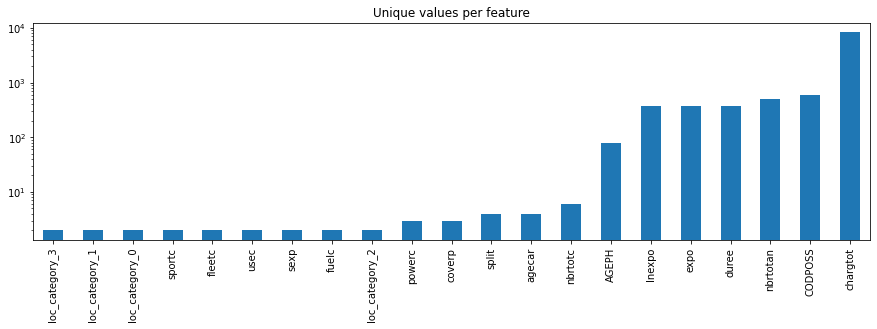

In [8]:
unique_values = data.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

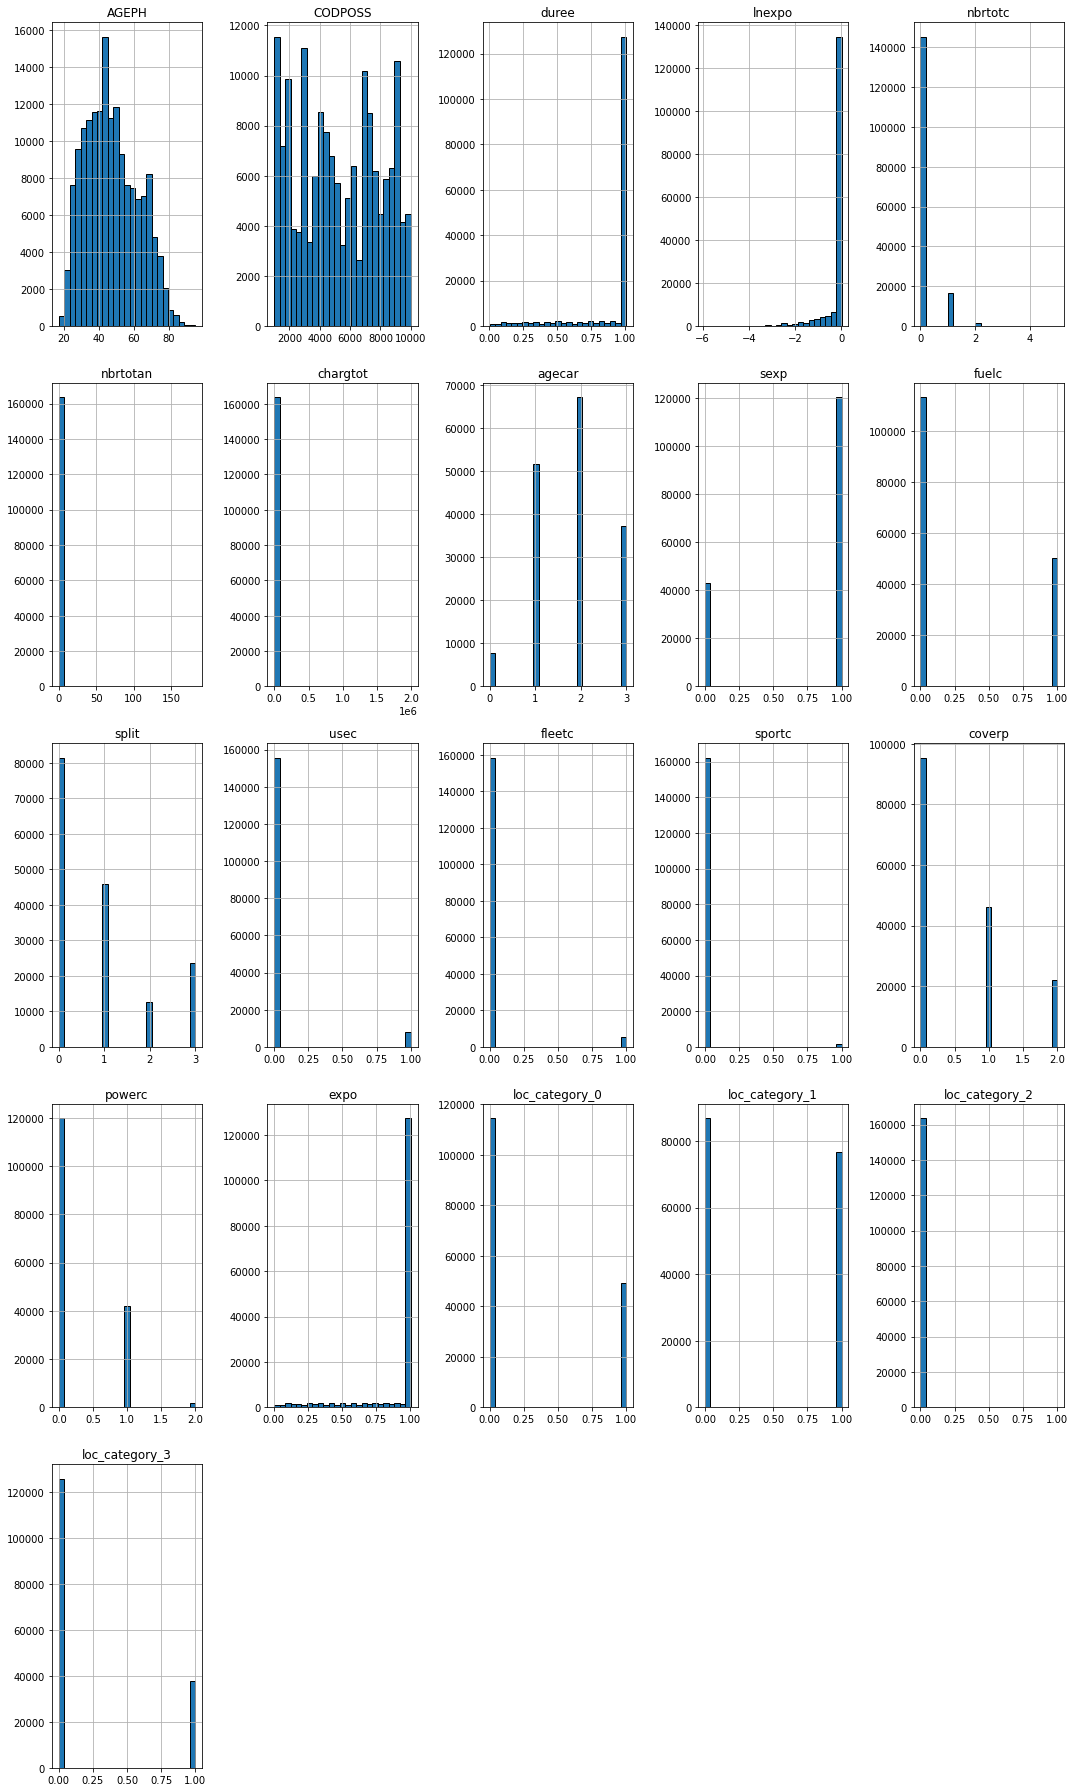

In [9]:
data.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

### 2.5 Feature columns  <a class="anchor" id="feature_cols"></a>

In [10]:
feat_cols = ['agecar','sexp','fuelc','split','usec','fleetc','sportc','coverp', 'powerc', 'AGEPH'] + [
    f'{ONE_HOT_PREFIX}{ONE_HOT_SEP}{i}' for i in range(N_CLUSTERS)
]

categorical_feat_cols = list(set(feat_cols) - set(['AGEPH']))

### 2.6 Train/test split  <a class="anchor" id="train_test"></a>

To avoid disbalance in the data the split was stratified to $nbrtotc>0$. 

Test set will be used for tarif adjustment.

In [11]:
X = data[feat_cols].copy()
#X['claims_pistive'] = data['nbrtotc'] > 0
y = data[['nbrtotc', 'chargtot', 'expo']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['nbrtotc'] > 0, random_state=42)

## 3 XGBoost  <a class="anchor" id="xgb"></a>

In this section XGboost-based models will be used to predict frequency and severety. Than the built models will be analysed.

In [12]:
def get_feat_importance(tree_based_alg, X):

    # Get the feature importances
    importances = tree_based_alg.feature_importances_

    # Create a dataframe to store the feature importances
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # Sort the dataframe by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(10, 6))

    # Plot the feature importances
    plt.bar(feature_importances['feature'], feature_importances['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()
    
    return pd.DataFrame(
        {
            'feature':tree_based_alg.feature_names_in_, 
            'importance':tree_based_alg.feature_importances_
        }
    ).sort_values('importance', ascending=False)

### 3.1 Frequency prediction  <a class="anchor" id="xgb_freq_pred"></a>

Target variable is average amount of claims per unit of exposure  $\frac{N_i}{d_i}$,

where $N_i$ - number of claims during the period of exposure $d_i$.

In [13]:
X_freq_train = X_train.copy()
y_freq_train = y_train['nbrtotc'] / y_train['expo']
w_freq_train = y_train['expo']

#### 3.1.1 Model building  <a class="anchor" id="xgb_freq_model"></a>

During model building process randomised grid search was used, to increase the code speed. Poisson deviance based scoring function is used, because of the distribution, of the frequency target variable.

In [14]:
param_dict_xgb = {'max_depth' : [1, 3, 5, 7, 9],
              'n_estimators' : [100, 200, 300],
              'colsample_bynode' : [0.5, 0.75, 1],
              'lambda' : [0, 0.1, 1],
              'alpha' : [0, 0.1, 1]}

xgb_init_freq = xgb.XGBRegressor(booster='gbtree',
                            learning_rate = 0.01,
                            objective='count:poisson',
                            eval_metric = 'poisson-nloglik',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            base_score = np.sum(y_freq_train * w_freq_train)/np.sum(w_freq_train))

In [15]:
%time 

xgb_randomsearch_freq = RandomizedSearchCV(estimator=xgb_init_freq,
                                      param_distributions=param_dict_xgb,
                                      scoring='neg_mean_poisson_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch_freq.fit(X_freq_train, y_freq_train, sample_weight=w_freq_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.13944292879289957,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='poisson-nloglik',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction...
                                          monotone_constraints=(1, 0, 0, 0, 0,
                                                                0, 0, 0, 0),
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='count:poisson',
                                          predictor=None, ...),
                   n_iter=2,
                   param_distributions={'alpha': [0, 0.1, 1],
                                        'colsample_bynode': [0.5, 0.75, 1],
                                        'lambda': [0, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_poisson_deviance',
                   verbose=1)

In [16]:
xgb_freq = xgb_randomsearch_freq.best_estimator_

#### 3.1.2 Interpretation   <a class="anchor" id="xgb_freq_interpretation"></a>

The most important features for frequency prediction are:
1. Age of the policyholder. As expected older policyholders are less risky, resulting in a lower amount of claims.
2. Split the premium. Not as obvious as age. It could be supposed that more frequent payments make people more responsible, reducing the number of claims. But the dependency is the opposite.
3. location_category_3. People from location_category_3 in general produce more claims than people from other locations.

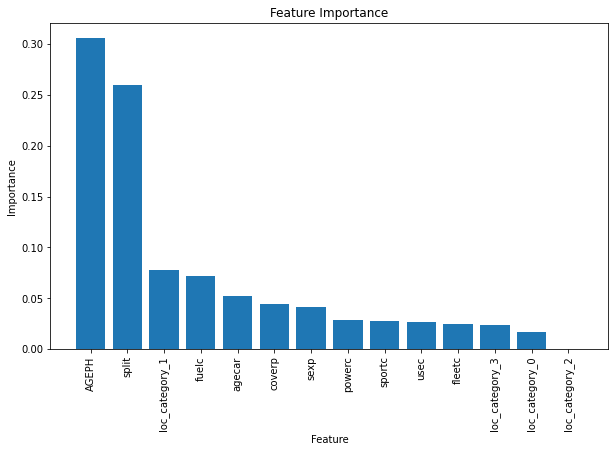

,feature,importance
9,AGEPH,0.305507
3,split,0.259538
11,loc_category_1,0.077802
2,fuelc,0.072325
0,agecar,0.051782
7,coverp,0.044030
1,sexp,0.041226
8,powerc,0.028150
6,sportc,0.027997
4,usec,0.026670


In [17]:
get_feat_importance(xgb_freq, X_freq_train)

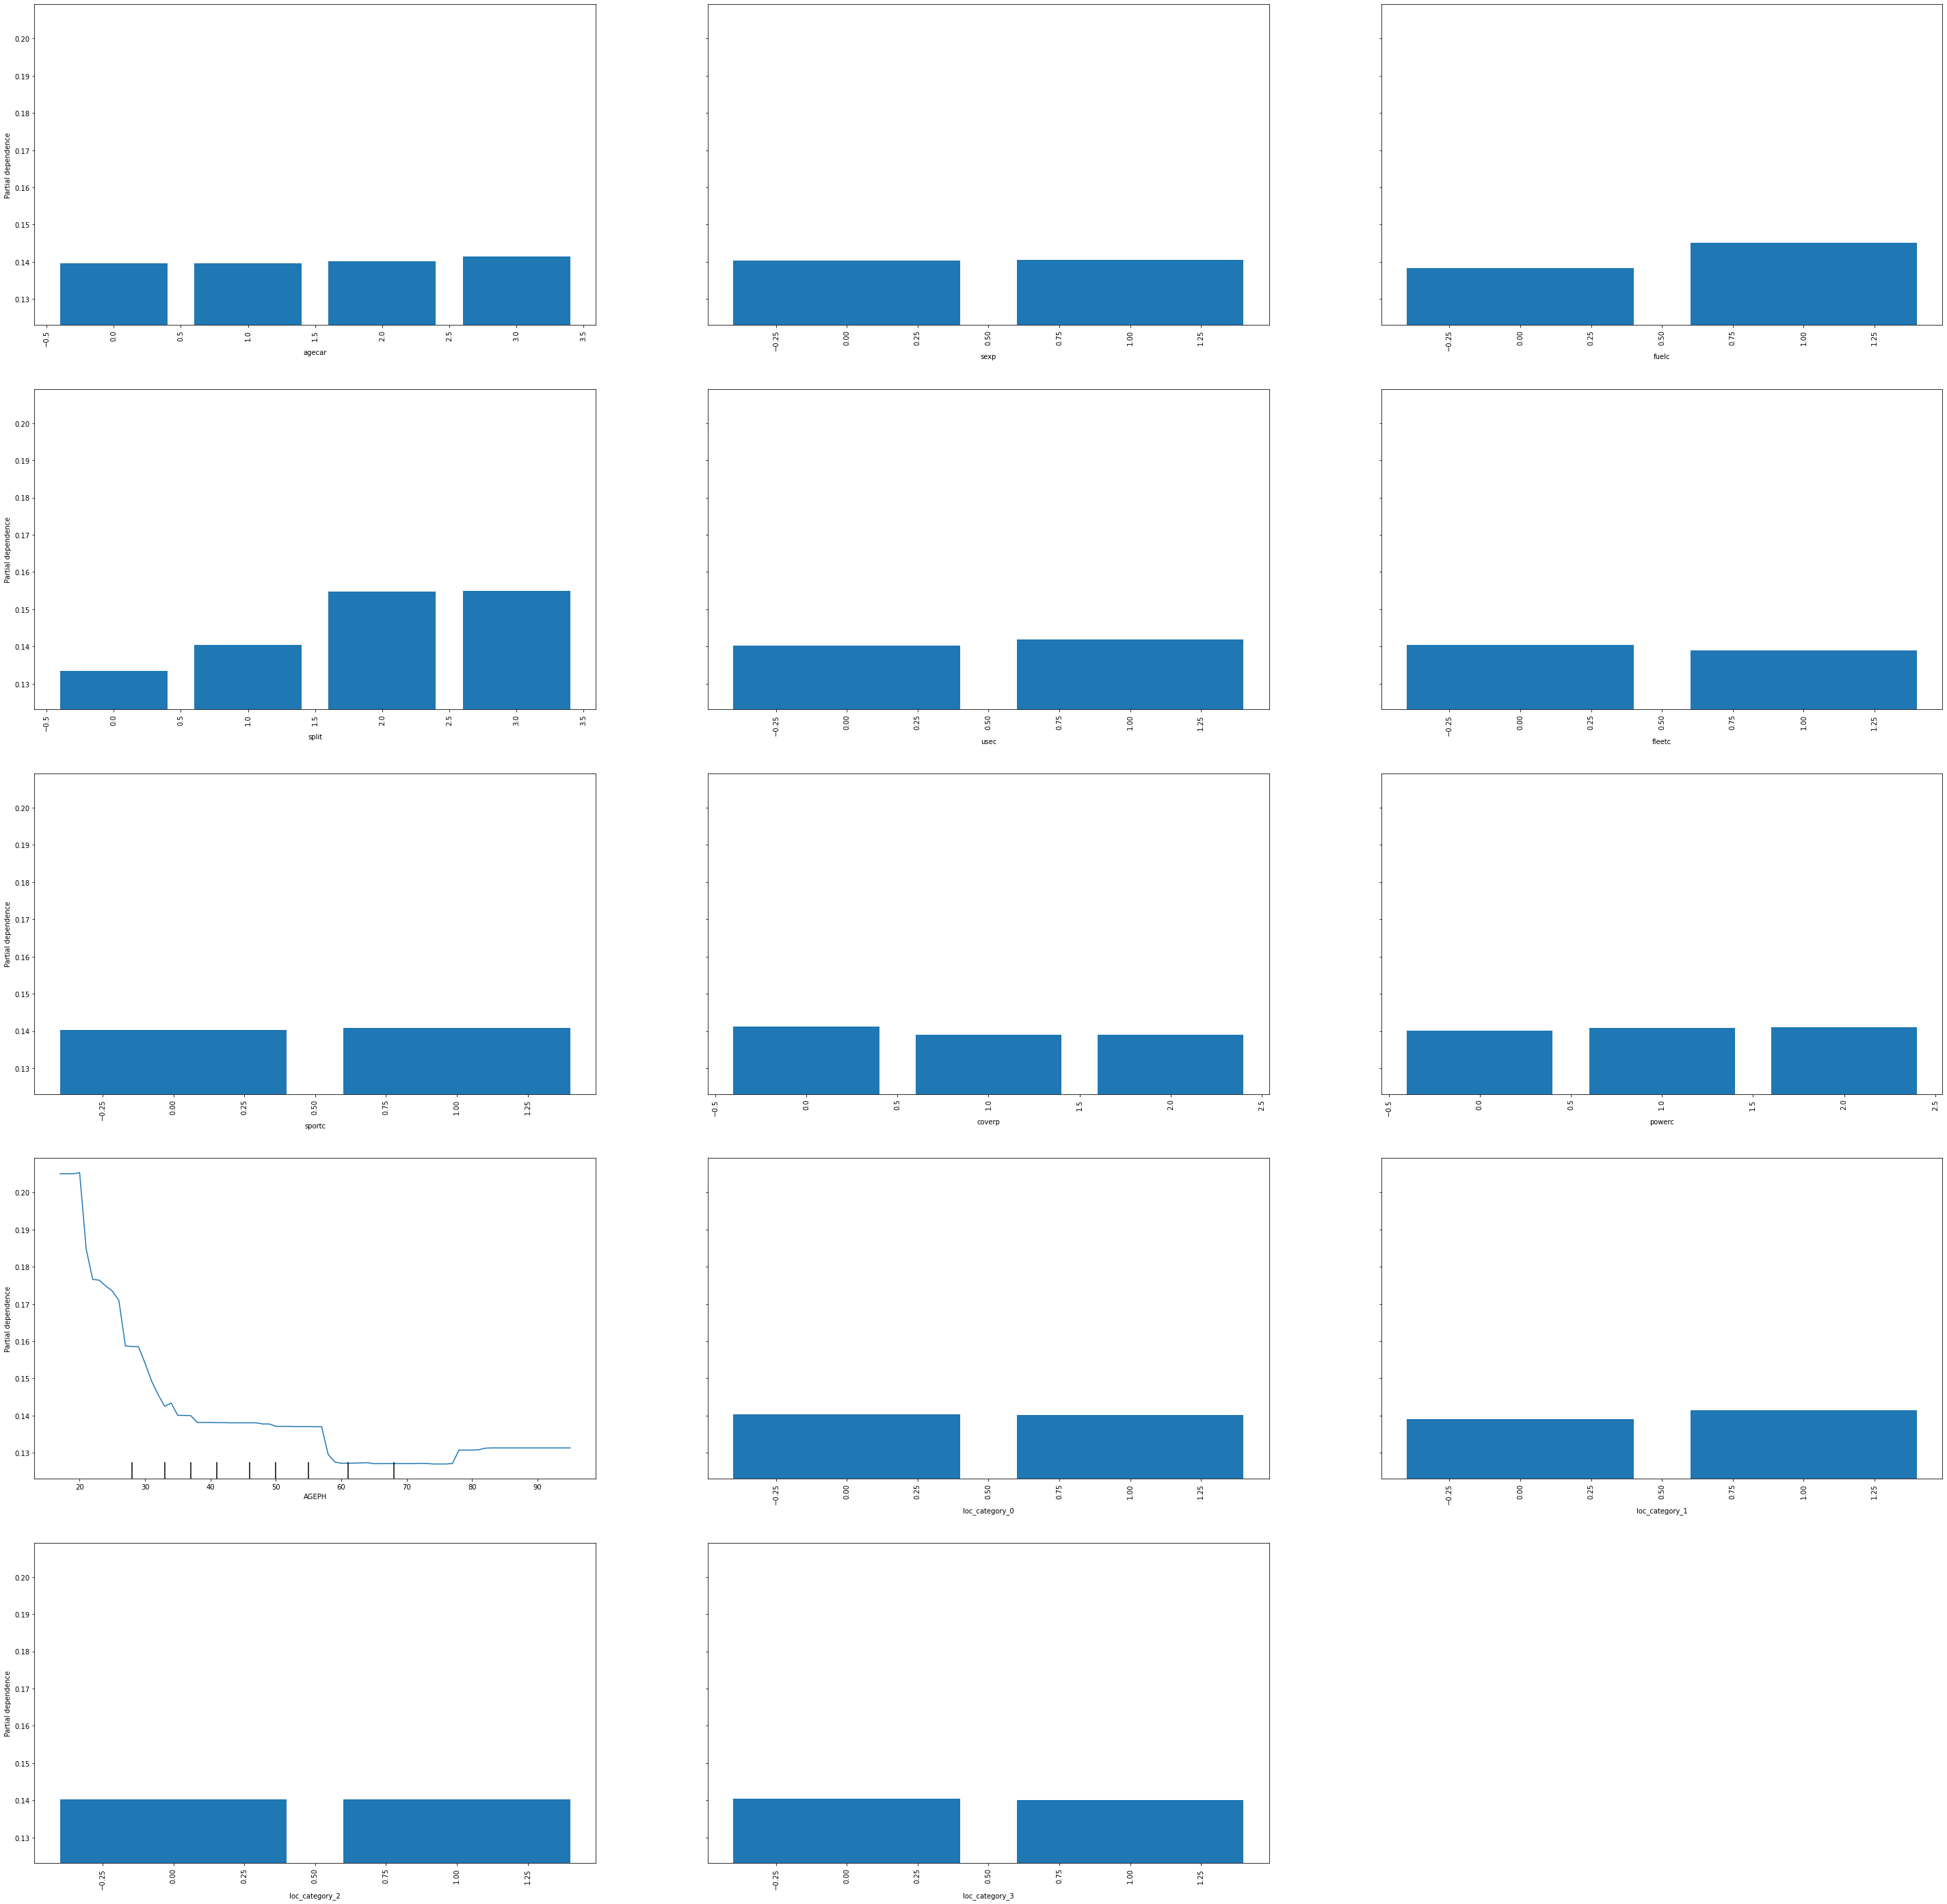

<Figure size 10800x10800 with 0 Axes>

In [18]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(xgb_freq, X_freq_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 3.2 Severity preidction   <a class="anchor" id="xgb_severity"></a>

Target variable is  average loss per claim for the policyholder $\frac{L_i}{N_i}$,

where $N_i$ - number of claim during the period of exposure $d_i$.

In [19]:
tmp = pd.concat([X_train, y_train], axis=1)
tmp = tmp[tmp['nbrtotc'] > 1]

X_sev_train = tmp[X_train.columns]
y_sev_train = tmp['chargtot'] / tmp['nbrtotc']
y_sev_log_train = np.log(y_sev_train)
w_sev_train = tmp['nbrtotc']

#### 3.2.1 Mode building    <a class="anchor" id="xgb_sev_model"></a>

The process in analogous to the model building for frequency data. The only difference is the usage of gamma distribution for the loss, because of the distribution of the severity variable.

In [20]:
xgb_init_sev = xgb.XGBRegressor(booster='gbtree',
                            learning_rate = 0.01,
                            objective='reg:gamma',
                            eval_metric = 'gamma-nloglik',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            base_score = np.sum(y_sev_train * w_sev_train)/np.sum(w_sev_train))

In [21]:
%time 

xgb_randomsearch_sev = RandomizedSearchCV(estimator=xgb_init_sev,
                                      param_distributions=param_dict_xgb,
                                      scoring='neg_mean_gamma_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch_sev.fit(X_sev_train, y_sev_train, sample_weight=w_sev_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=1513.2623052328586,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='gamma-nloglik',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          monotone_constraints=(1, 0, 0, 0, 0,
                                                                0, 0, 0, 0),
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:gamma', predictor=None, ...),
                   n_iter=2,
                   param_distributions={'alpha': [0, 0.1, 1],
                                        'colsample_bynode': [0.5, 0.75, 1],
                                        'lambda': [0, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_gamma_deviance',
                   verbose=1)

In [22]:
xgb_sev = xgb_randomsearch_sev.best_estimator_

#### 3.2.2 Interpretation    <a class="anchor" id="xgb_sev_interpretation"></a>


The most important features for severity prediction are:
1. location_category_0. People from location_category_0 in general produce losses per claim, than people from other locations.
2. Coverage. It is noticeable that coverage importance is lower than location importance, but nevertheless, the difference is not too big. People with big and small coverages produce bigger claim sizes, while mid-coverage produces smaller. This can be explained in the following way. Policyholders with smaller coverage feel less responsible and behave more riskily. And people with bigger coverage can buy policies with bigger coverage because of their risky behavior in general.

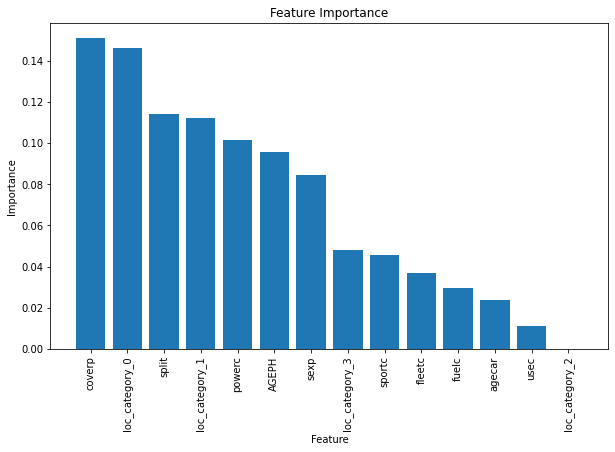

,feature,importance
7,coverp,0.150795
10,loc_category_0,0.146170
3,split,0.114241
11,loc_category_1,0.112214
8,powerc,0.101406
9,AGEPH,0.095786
1,sexp,0.084502
13,loc_category_3,0.048048
6,sportc,0.045645
5,fleetc,0.036822


In [23]:
get_feat_importance(xgb_sev, X_sev_train)

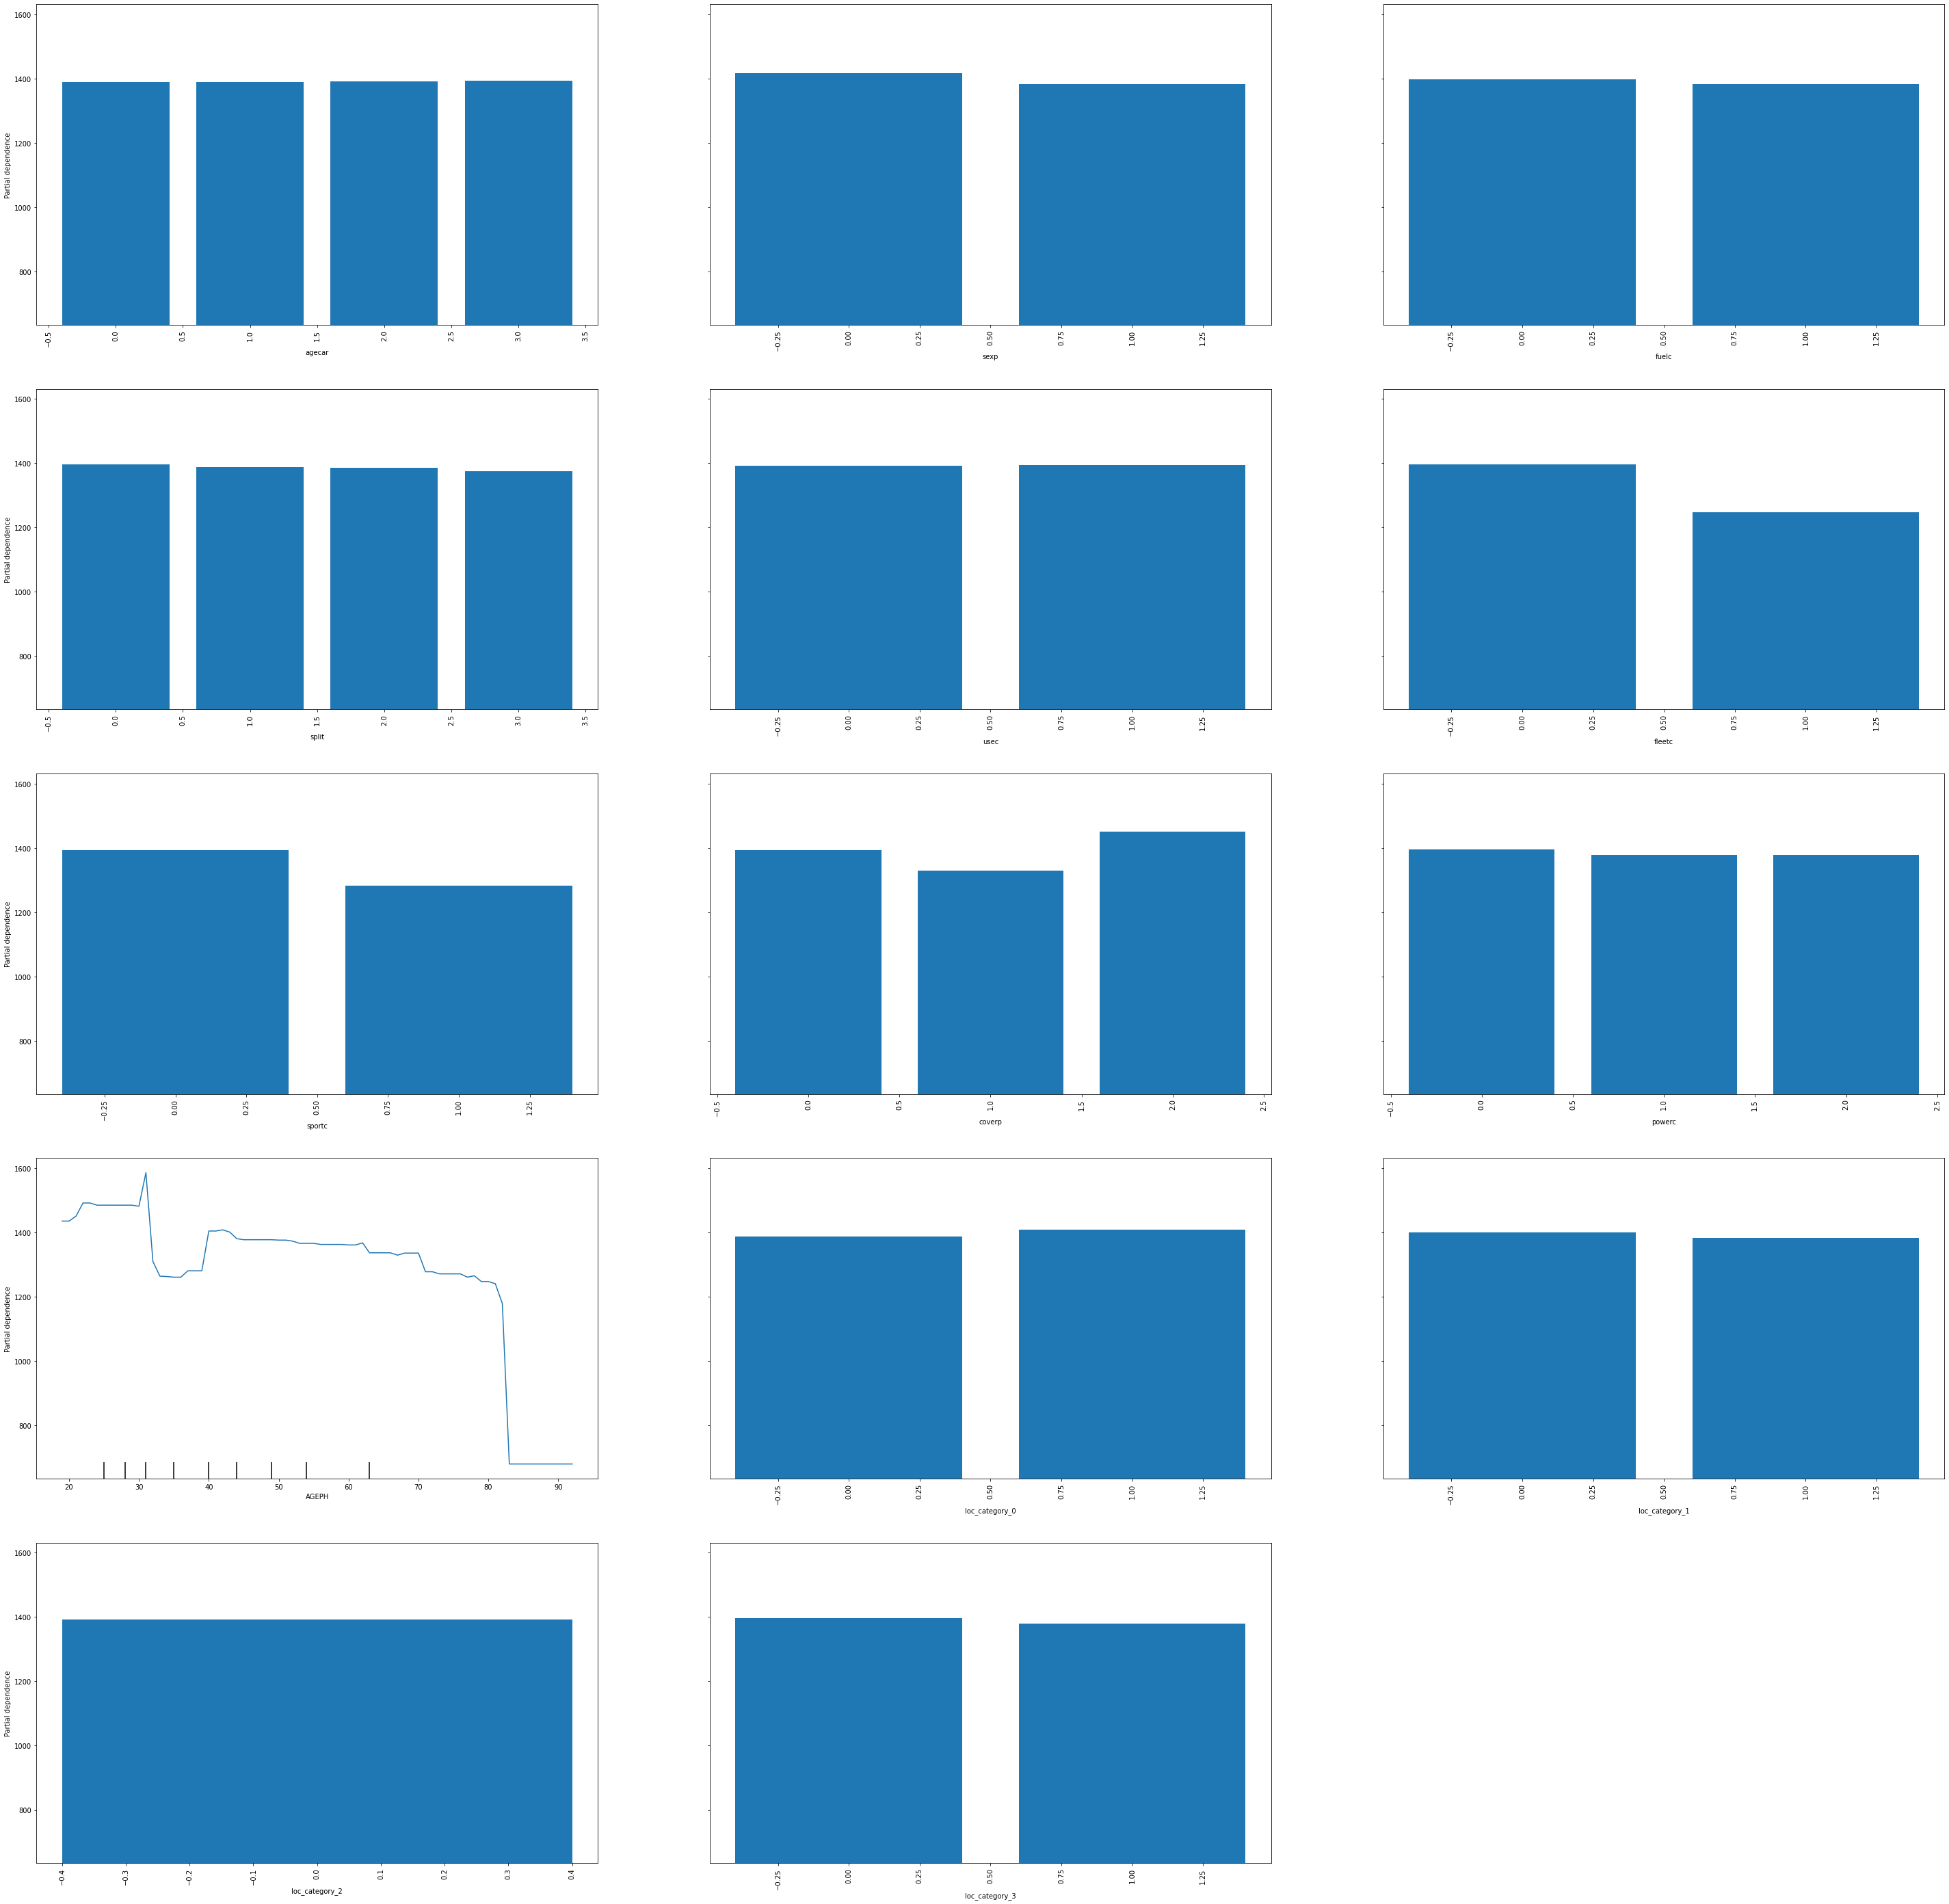

<Figure size 10800x10800 with 0 Axes>

In [24]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(xgb_sev, X_sev_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 3.3 Caluclations safety demonstration       <a class="anchor" id="xgb_safety"></a>

The approach followed in 'Boosting Insights in Insurance Tariff Plans with Tree-Based Machine Learning Methods' was adapted.

Observed losses, taken as the sum of $chargtot$ column are compared with technical premium $\pi_i$. $\pi_i$ is calculated in the following way:

$$\pi_{i}=E(\frac{N_i}{d_i})E(\frac{L_{i}}{N_{i}})=\hat{f} \hat{s}$$,

where $\hat{f}$ – prediction of the frequency model, $\hat{s}$ – prediction of the severity model.

<br>


All the comparisons are made on the test data, obtained in the previous section to see how the approach will deal with unseen data.

<br>


**In general the XGBoost-based prediction underestimates the actual losses on 15.9%.**





___
Henckaerts, R., Côté, M.-P., Antonio, K., & Verbelen, R. (2020). Boosting Insights in Insurance Tariff Plans with Tree-Based Machine Learning Methods. Variance, 14(1), 82-108. https://doi.org/10.21314/JOP.2020.197


In [25]:
total_loss = y_test['chargtot'].sum()
exposure = y_test['expo']


In [26]:
xbg_pred_freq = xgb_freq.predict(X_test)
xbg_pred_sev = xgb_sev.predict(X_test)#tmp['chargtot'] / tmp['nbrtotc']

xgb_tech_premium = xbg_pred_freq * xbg_pred_sev

loss_premium_fraction = total_loss / sum(xgb_tech_premium * exposure)

pd.DataFrame({
    'Total loss': round(total_loss),
    'Total premium': round(sum(xgb_tech_premium * exposure)),
    'Total loss/total premium': round(loss_premium_fraction, 3)
}, index=['XGBoost'])


,Total loss,Total premium,Total loss/total premium
XGBoost,6431450,5548154,1.159


In [27]:
5551237 * loss_premium_fraction

6435024.234145533

## 4 Random forest        <a class="anchor" id="rf"></a>


In this section, random forest models will be used to predict frequency and severity. Then the built models will be analyzed.

### 4.1 Frequency prediction      <a class="anchor" id="rf_freq_pred"></a>


#### 4.1.1 Model building   <a class="anchor" id="rf_freq_model"></a>

Same approach as for XGBoost frequency model.

In [28]:
param_dict_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_init_freq = RandomForestRegressor(random_state=42)

In [29]:
%time

rf_randomsearch_freq = RandomizedSearchCV(estimator=rf_init_freq,
                                      param_distributions=param_dict_rf,
                                     scoring='neg_mean_poisson_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
rf_randomsearch_freq.fit(X_freq_train, y_freq_train, sample_weight=w_freq_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_poisson_deviance',
                   verbose=1)

In [30]:
rf_freq = rf_randomsearch_freq.best_estimator_

#### 4.1.2 Interpretation     <a class="anchor" id="rf_interpretation"></a>

The built model is consistent with the XGBoost model.

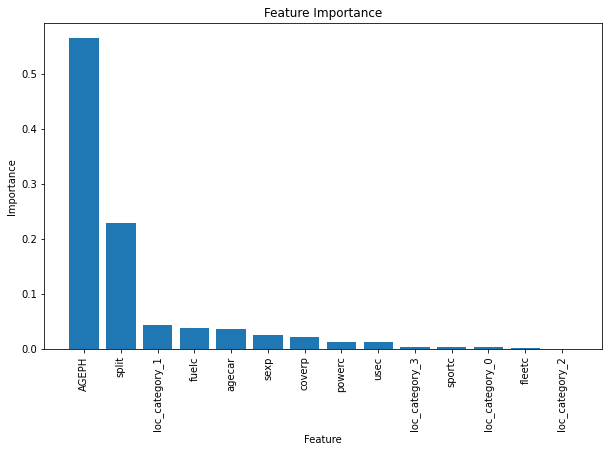

,feature,importance
9,AGEPH,0.564384
3,split,0.229268
11,loc_category_1,0.043691
2,fuelc,0.038882
0,agecar,0.036853
1,sexp,0.026412
7,coverp,0.021517
8,powerc,0.012375
4,usec,0.012108
13,loc_category_3,0.004114


In [31]:
get_feat_importance(rf_freq, X_freq_train)

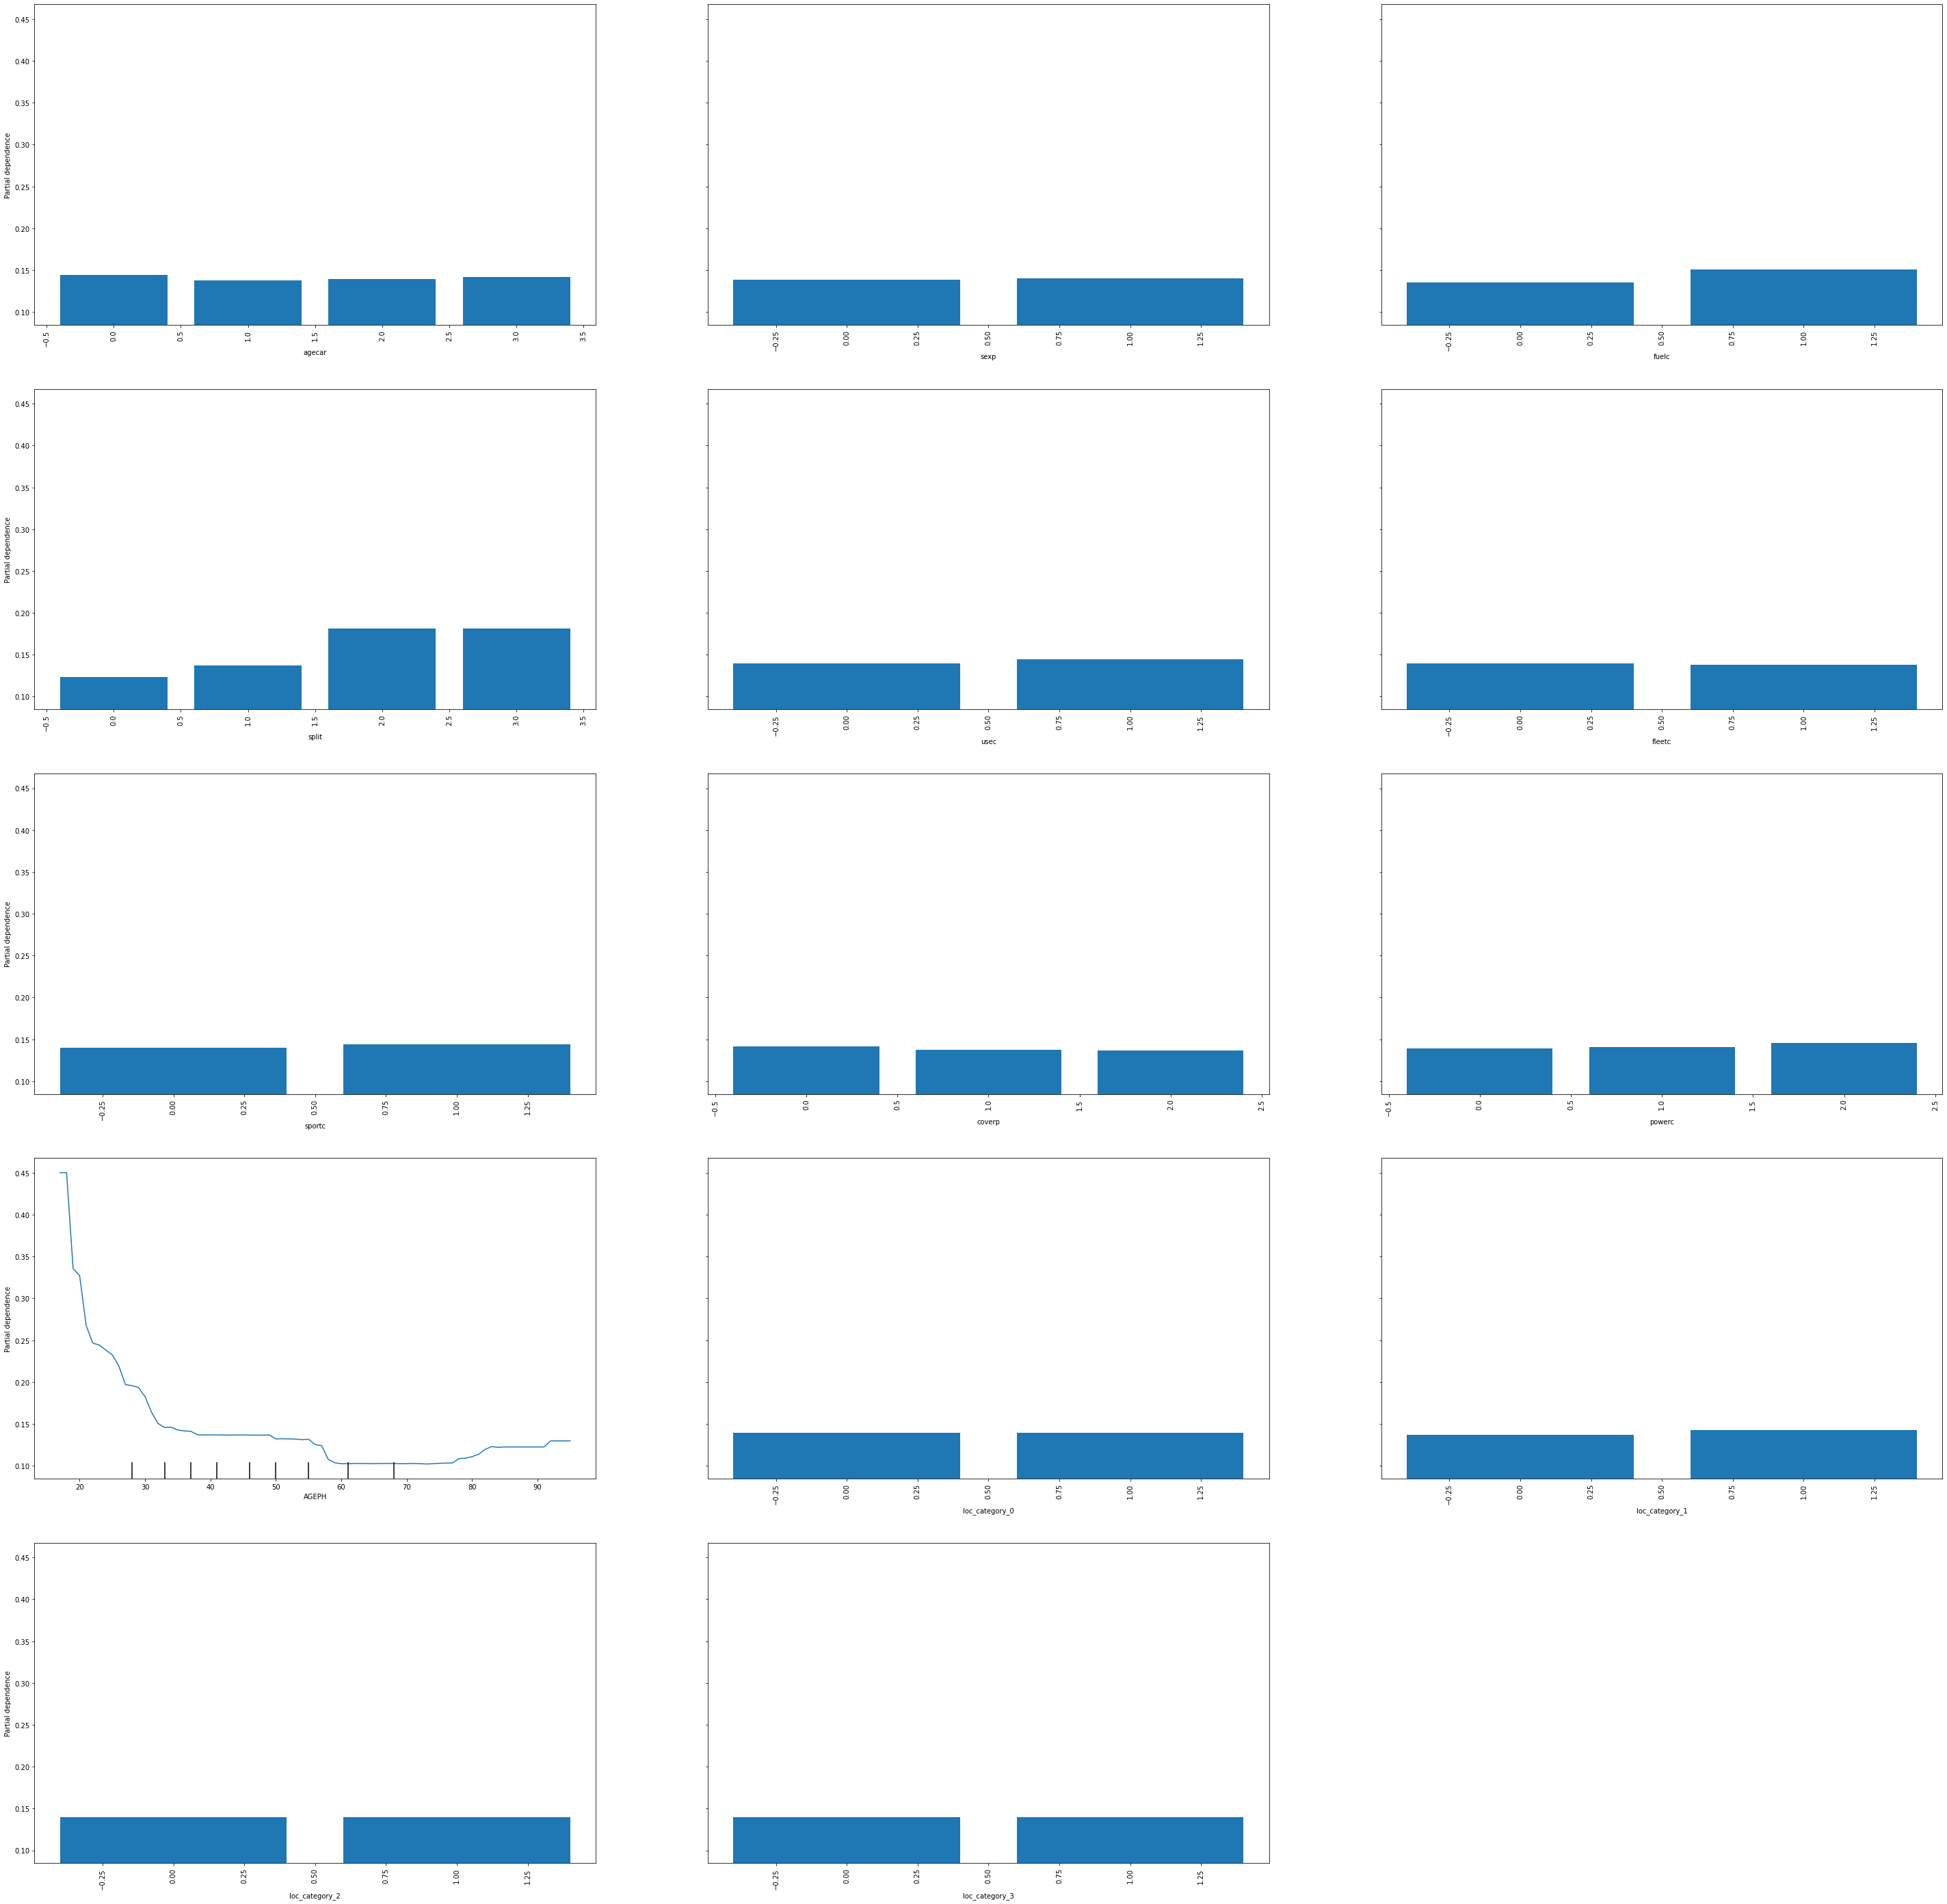

<Figure size 10800x10800 with 0 Axes>

In [32]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(rf_freq, X_freq_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 4.2 Severity preidiction    <a class="anchor" id="rf_sev_pred"></a>

#### 4.2.1 Model building    <a class="anchor" id="rf_sev_model"></a>

Same as for XGBoost severity model.

In [33]:
rf_init_sev = RandomForestRegressor(random_state=42)

In [34]:
%time 

rf_randomsearch_sev = RandomizedSearchCV(estimator=rf_init_sev,
                                      param_distributions=param_dict_rf,
                                     scoring='neg_mean_gamma_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
rf_randomsearch_sev.fit(X_sev_train, y_sev_train, sample_weight=w_sev_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_gamma_deviance',
                   verbose=1)

In [35]:
rf_sev = rf_randomsearch_sev.best_estimator_

#### 4.2.2 Interpretation       <a class="anchor" id="rf_sev_interpretation"></a>

The severity random forest model's feature importances significantly differ from the one obtained with XGBoost.

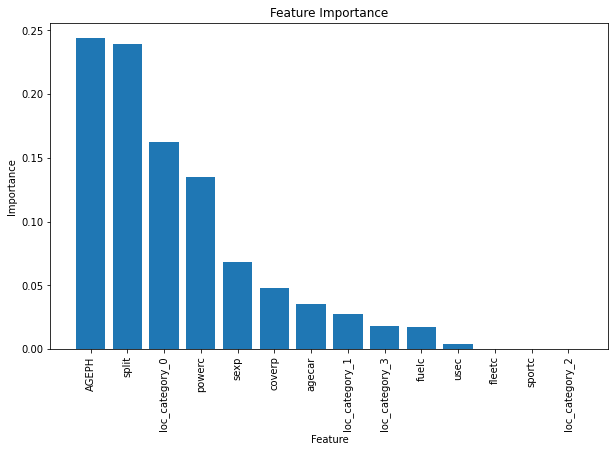

,feature,importance
9,AGEPH,0.243628
3,split,0.239187
10,loc_category_0,0.162782
8,powerc,0.135010
1,sexp,0.068507
7,coverp,0.047742
0,agecar,0.035533
11,loc_category_1,0.027215
13,loc_category_3,0.018457
2,fuelc,0.017554


In [36]:
get_feat_importance(rf_sev, X_sev_train)

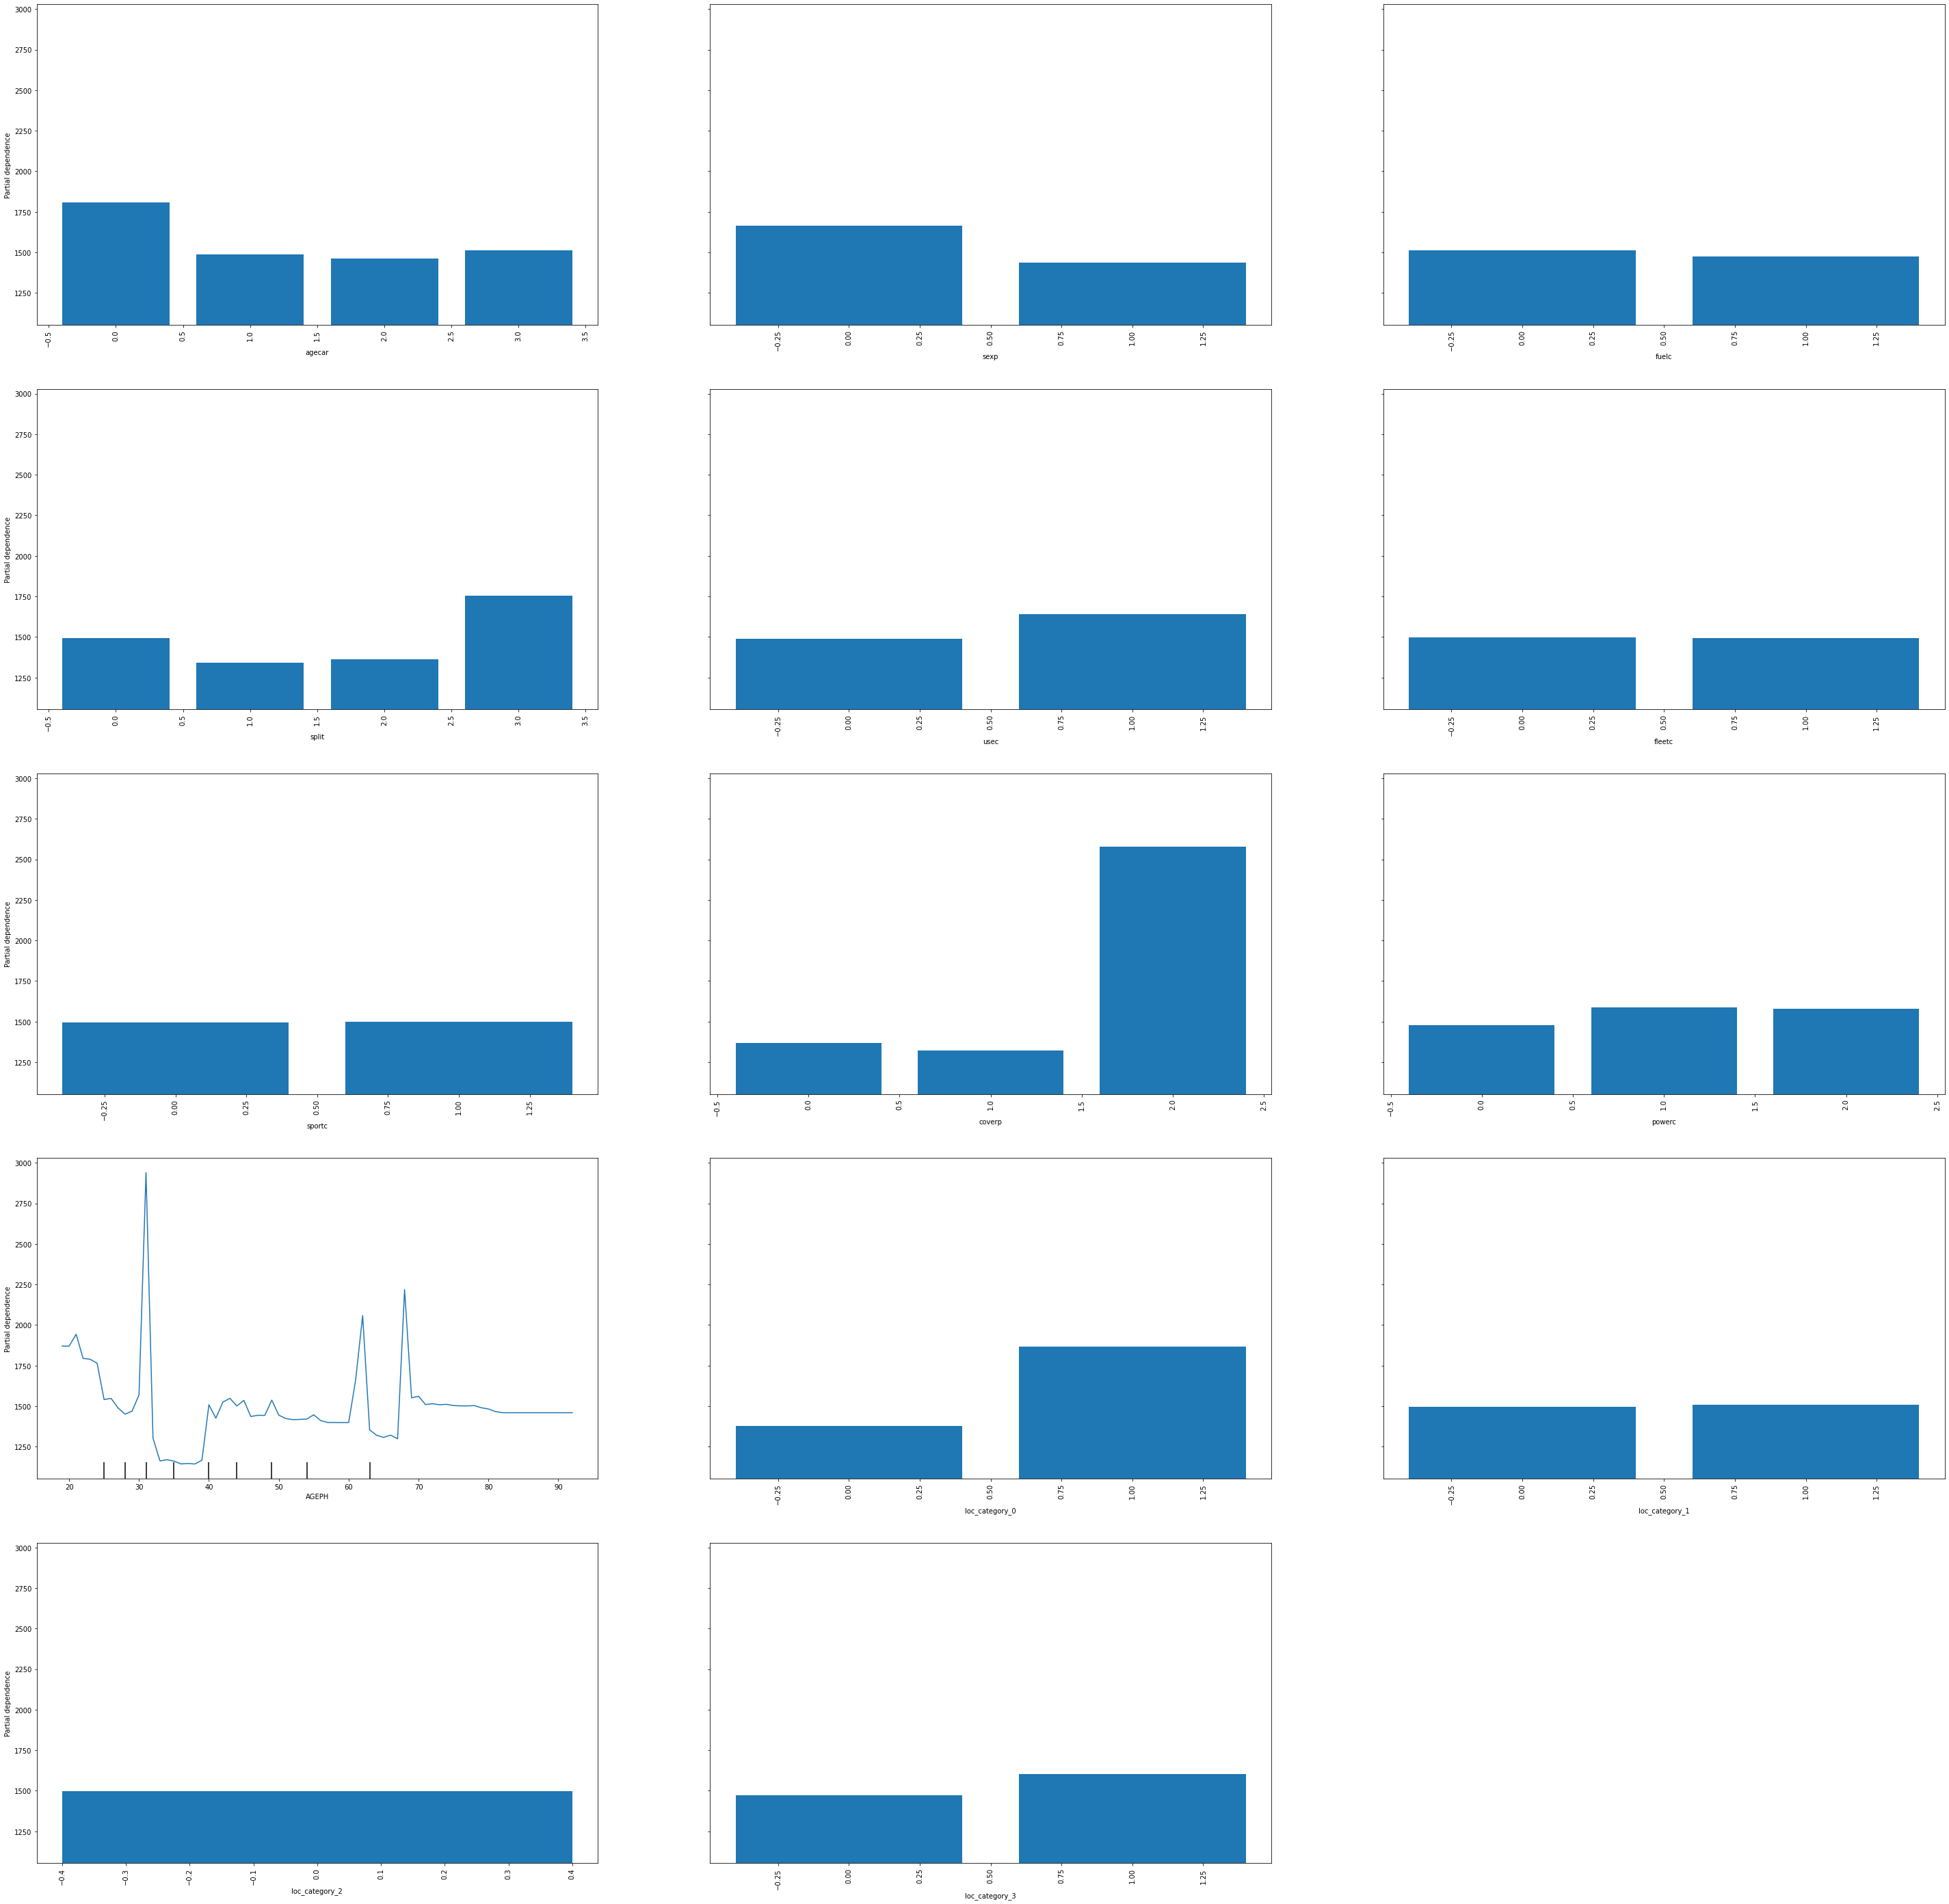

<Figure size 10800x10800 with 0 Axes>

In [37]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(rf_sev, X_sev_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 4.3 Caluclation safety demonstration      <a class="anchor" id="rf_safety"></a>


For random forest models, the same approach as for XGBoost was applied. **On average the random forest-based prediction underestimates the actual losses on 2.1%**.

In [38]:
rf_pred_freq = rf_freq.predict(X_test)
rf_pred_sev = rf_sev.predict(X_test)#tmp['chargtot'] / tmp['nbrtotc']

rf_tech_premium = rf_pred_freq * rf_pred_sev

loss_premium_fraction = total_loss / sum(rf_tech_premium * exposure)

pd.DataFrame({
    'Total loss': round(total_loss),
    'Total premium': round(sum(rf_tech_premium * exposure)),
    'Total loss/total premium': round(loss_premium_fraction, 3)
}, index=['XGBoost'])

,Total loss,Total premium,Total loss/total premium
XGBoost,6431450,6297198,1.021


# Conclusion   <a class="anchor" id="conclusion"></a>

During the assignment, two predictive models were built. In addition for each model feature interpretation tools were plotted. The best-performing model underestimated potential losses on 2.1% on test data.